# Partial Dependence  Documentation

This notebook is designed to demonstrate how to use `skexplain` to compute 1D or 2D partial dependence (PD) and plot the results. PD can be used to assess feature importance, feature attributions, and feature interactions. For more information on dataset and initializing `ExplainToolkit`, see the permutatation importance notebook. The concept and calculation of PD is too much to cover in this notebook. We highly recommend readers to check out [Christoph Molnar's chapter on PD](https://christophm.github.io/interpretable-ml-book/pdp.html). 

In [1]:
import sys, os 
current_dir = os.getcwd()
path = os.path.dirname(current_dir)
sys.path.append(path)

In [2]:
import skexplain
import plotting_config 
import itertools

## Loading the training data and pre-fit models 

In [3]:
estimators = skexplain.load_models()
X,y = skexplain.load_data()

### Loading permutation importance results

In [4]:
explainer = skexplain.ExplainToolkit(estimators, X=X, y=y,)
# Load the permutation important results from the saved pickle file
results = explainer.load(fnames='multipass_importance_naupdc.nc',)
important_vars = explainer.get_important_vars(results, multipass=True, n_vars=5, combine=True)

# Partial Dependence Plots

To limit the scope of our analysis, we can start by plotting the PD for the most important features. Assuming we have already run the permutation importance, we can pass those into `.get_important_vars`. If we are using multiple models, we can set `combine=True` and this function will make a single list of important predictors (removing duplicates). From this single list, we can ask for only a subset of features (`n_vars=7`). Otherwise, the function will return a dict with the model names as keys with the top features as items. 

To personalize your plots, you can pass a dict `display_feature_names`, which should map the feature names with a prettier, more interpretable name. To see our example of `display_feature_names`, look in `plotting_config.py`. Note that once you develop your own mapping dictionary, it can be used throughout the MintPy plotting suite. 

In [5]:
important_vars = ['sfcT_hrs_bl_frez', 'temp2m',  'sfc_temp', 'uplwav_flux']
pd_1d_ds = explainer.pd( features=important_vars, 
                                 n_bootstrap=1, 
                                 subsample=1000,
                                 n_jobs=len(important_vars)*3,
                                 n_bins=10
                                )

  0%|          | 0/12 [00:00<?, ?it/s]

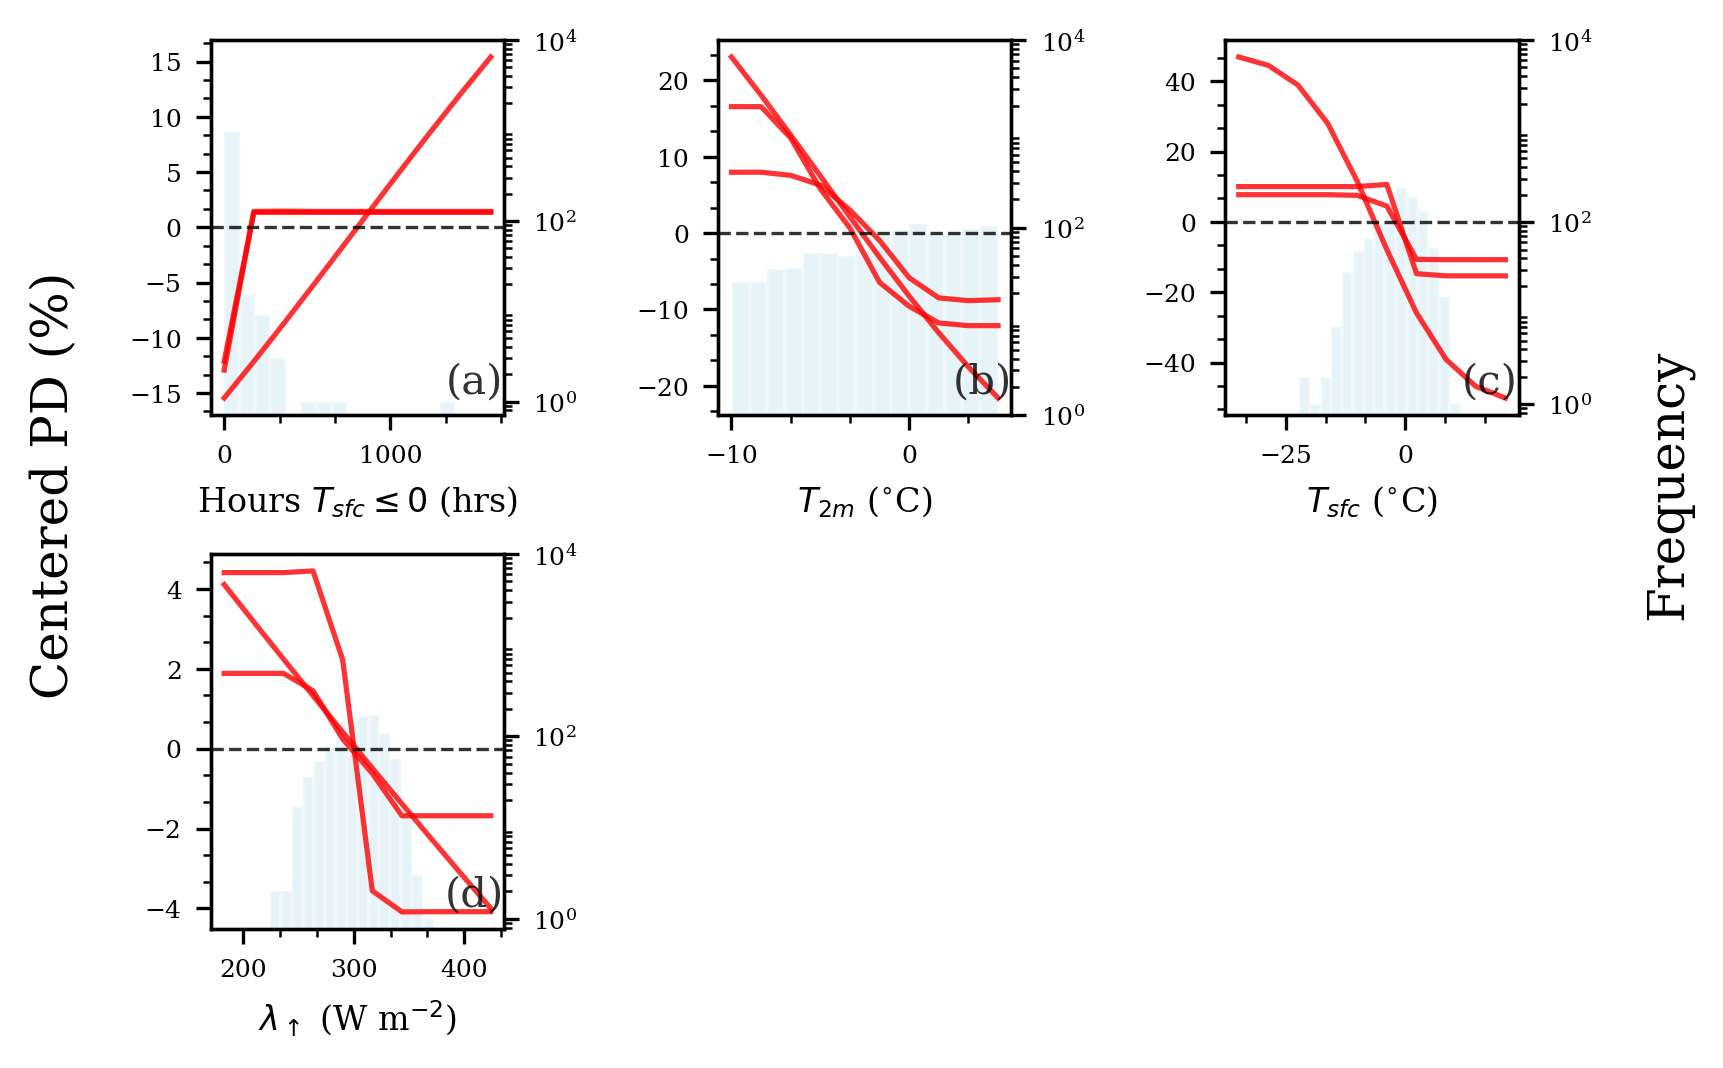

In [6]:
fig, axes = explainer.plot_pd(pd=pd_1d_ds, display_units=plotting_config.display_units,
                                   display_feature_names=plotting_config.display_feature_names,
                                  )

  0%|          | 0/9 [00:00<?, ?it/s]

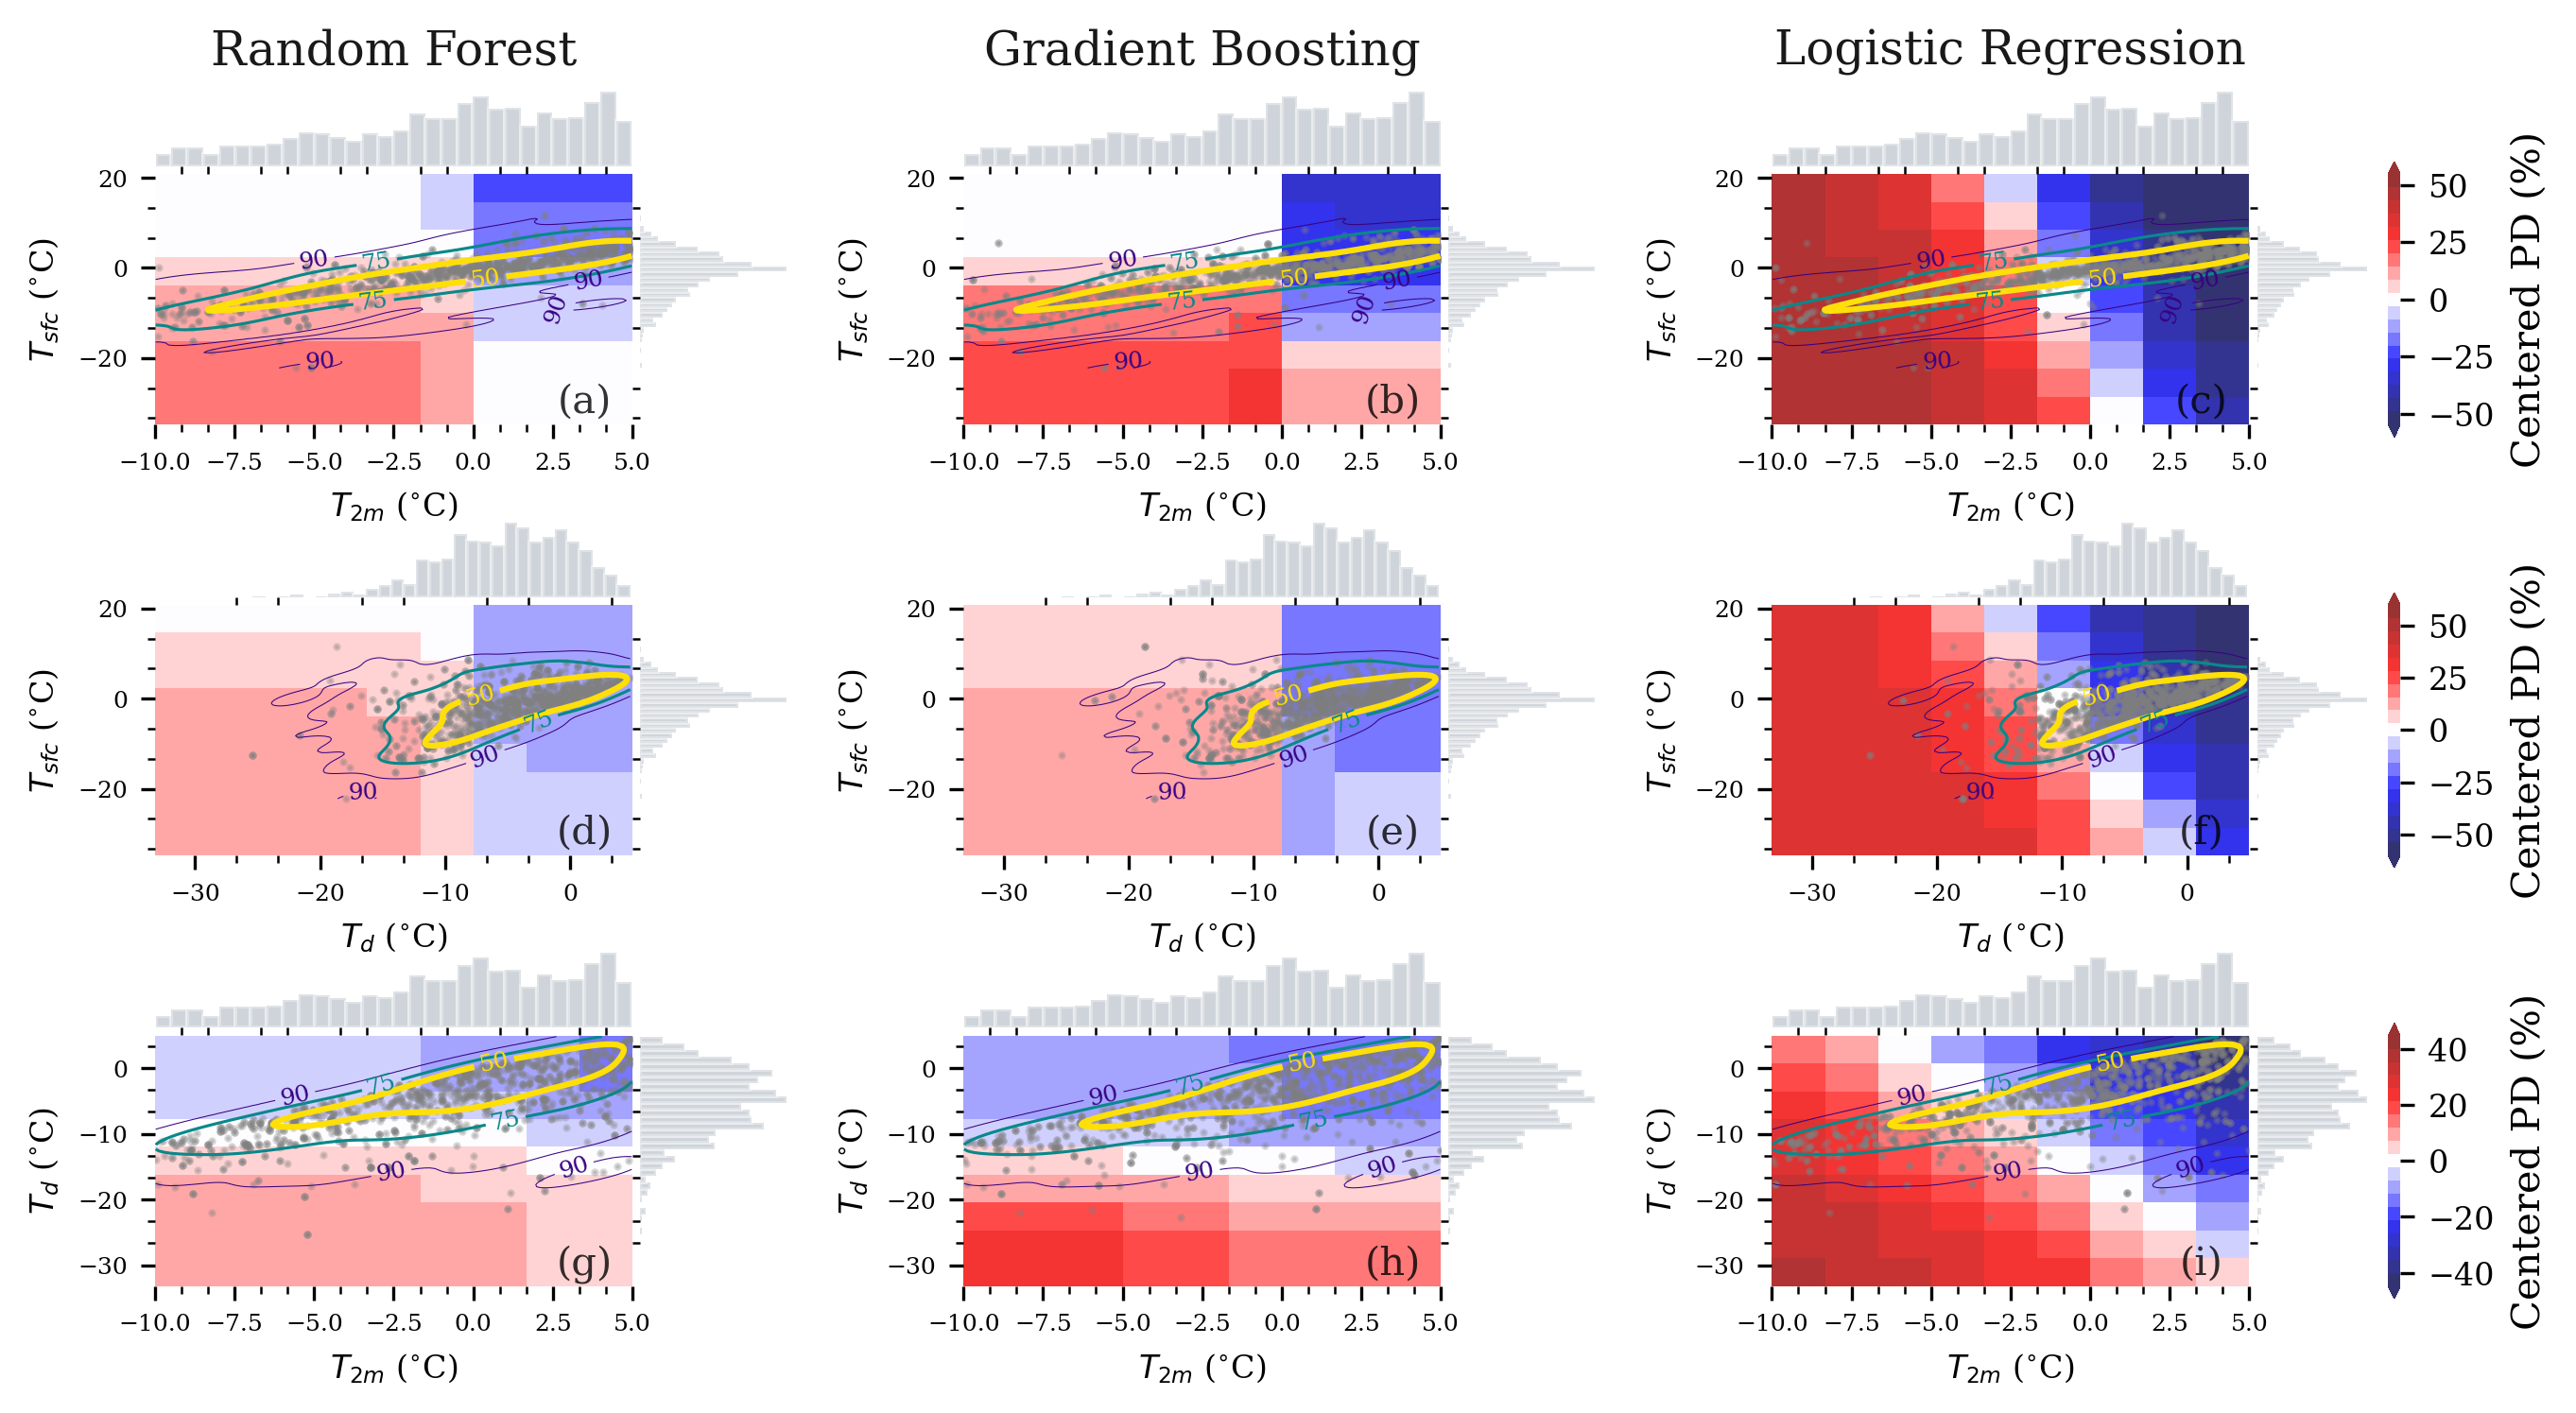

In [7]:
features=[('temp2m', 'sfc_temp'), ('dwpt2m', 'sfc_temp'), ('temp2m', 'dwpt2m')]
pd_2d_ds = explainer.pd(features=features, 
                                 n_bootstrap=1, 
                                 subsample=1000,
                                 n_jobs=len(features)*3,
                                 n_bins=10
                                )

fig, axes = explainer.plot_pd(pd=pd_2d_ds, 
                                  display_units=plotting_config.display_units,
                                   display_feature_names=plotting_config.display_feature_names,
                                  )

## Friedman's Second-order H-statistic

Using PD, we compute the Friedman H-statistic that quantifies the degree to which two features interact with each other. If the two features do not interact, then their second-order PD will equal the sum of their first order effects. 


In [8]:
important_vars_2d = list(itertools.combinations(important_vars, r=2))
n_bins=10
subsample=1000
pd_1d = explainer.pd(features=important_vars, n_bins=n_bins, subsample=subsample, n_bootstrap=20, n_jobs=8)
pd_2d = explainer.pd(features=important_vars_2d, n_bins=n_bins, subsample=subsample, n_bootstrap=20, n_jobs=8)
# Compute the H-statistic 
hstat_results= explainer.friedman_h_stat(pd_1d=pd_1d, pd_2d=pd_2d, features=important_vars_2d,)

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

The small value of the second-order H-statistics suggests that 2-m temperature and surface temperature do not strongly interact with the Random Forest for predicting sub-freezing road temperatures. This is not surprisingly given that these features are highly correlated.

(<Figure size 1800x750 with 5 Axes>,
 array([<AxesSubplot:title={'center':'Random Forest'}>,
        <AxesSubplot:title={'center':'Gradient Boosting'}>,
        <AxesSubplot:title={'center':'Logistic Regression'}>], dtype=object))

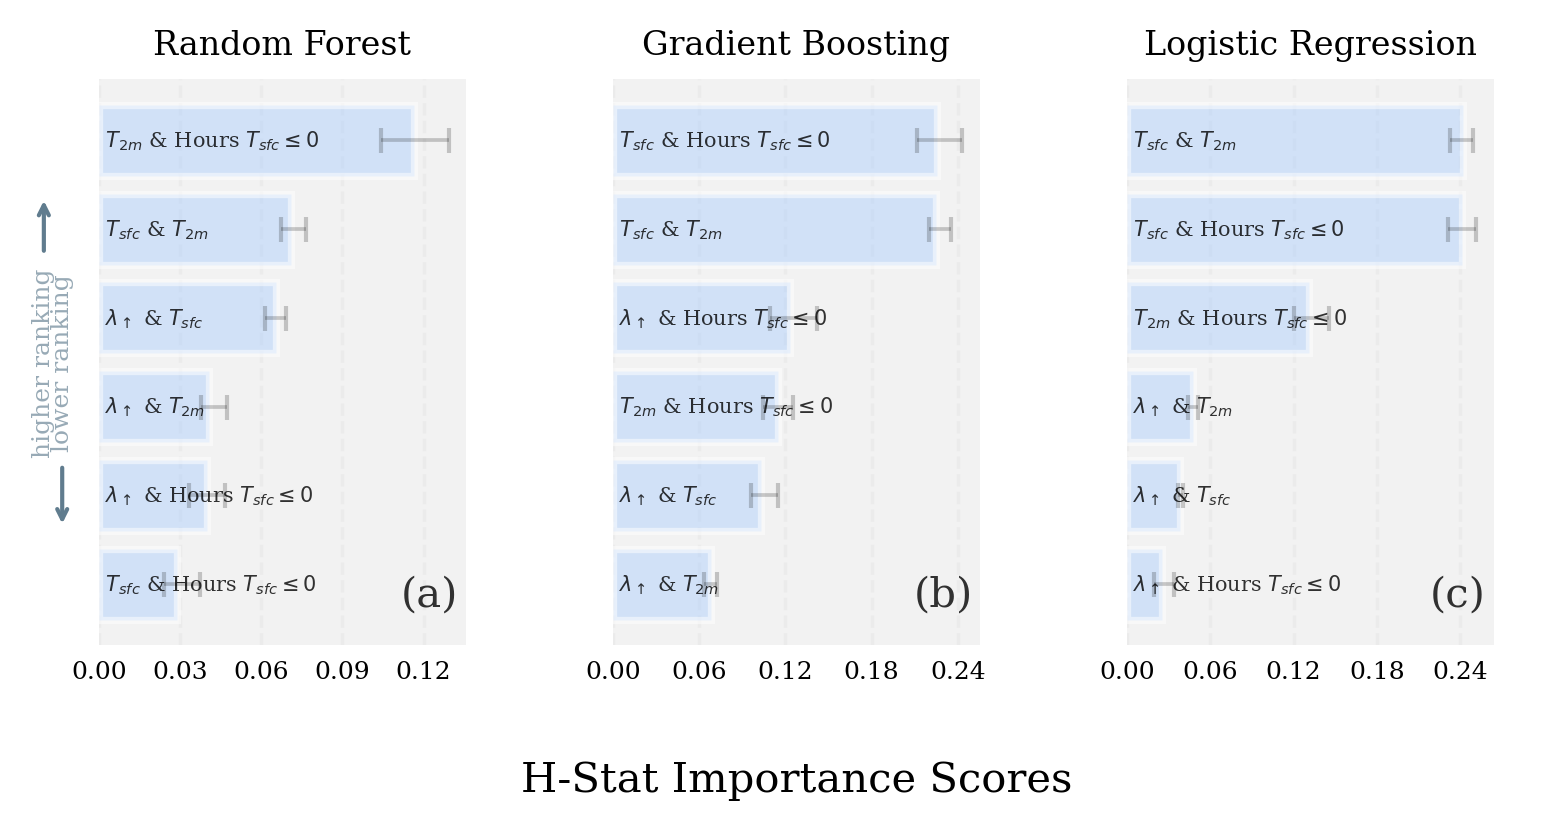

In [12]:
adict = plotting_config.display_feature_names
display_feature_names = {f'{f[0]}__{f[1]}': f'{adict[f[1]]} & {adict[f[0]]}' 
                         for f in important_vars_2d}

explainer.plot_importance(data=hstat_results, 
                          panels = [('hstat', 'Random Forest' ), 
                                    ('hstat', 'Gradient Boosting' ), 
                                    ('hstat', 'Logistic Regression' ), 
                                   ],
                             display_feature_names=display_feature_names,
                             )

In this example, we can see that correlated pairs are among the top interactions, which are spurious interactions. However, there does appear to be an association between the multiple features and the hour the surface temperature has been below zero. Though it would require further exploration, this result aligns with our expectations that freezing road surfaces are the result of cooler temperatures over a long period of time. 